In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import tensorflow as tf
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
def plot_graphs(history):
    fig = go.Figure()

    fig = make_subplots(rows=1, cols=2)

    fig.append_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='Train Accuracy',
            mode='lines+markers'
        ),
        row=1, col=1
    )

    fig.append_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='Validation Accuracy',
            mode='lines+markers'
        ),
        row=1, col=1
    )

    fig.append_trace(
        go.Scatter(
            y=history.history['loss'],
            name='Train Loss',
            mode='lines+markers'
        ),
        row=1, col=2
    )

    fig.append_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='Validation Loss',
            mode='lines+markers'
        ),
        row=1, col=2
    )

    fig.update_layout(height=500, width=1000, title_text="Accuracy and Loss", template="plotly_dark")
    fig.show()

In [3]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices)) 

1


In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

batch_size = 32
width = 128
height = 128

data_dir = 'real-vs-fake/'

Text(0.5, 1.0, 'Real')

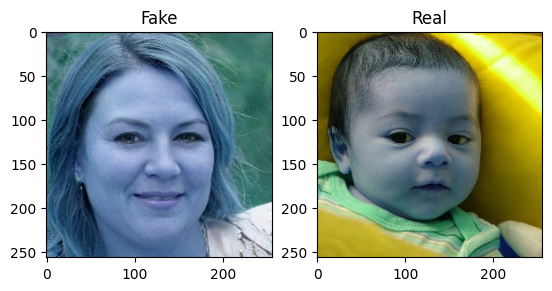

In [5]:
fig, axs = plt.subplots(1, 2)
fake = cv2.imread(data_dir + 'train/fake/0A0IAK9X2W.jpg')
real = cv2.imread(data_dir + 'train/real/00000.jpg')
axs[0].imshow(fake)
axs[0].set_title('Fake')
axs[1].imshow(real)
axs[1].set_title('Real')

In [6]:
train_ds = image_dataset_from_directory(
    data_dir+"/train",
    validation_split = 0.2,
    subset = 'training',
    seed = 200,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    data_dir+"/test",
    validation_split = 0.2,
    subset = 'validation',
    seed = 200,
    image_size = (width, height),
    batch_size = batch_size,
    label_mode = 'binary'
)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Metal device set to: Apple M2


2023-05-29 11:37:54.784221: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-29 11:37:54.784583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [7]:
model = tf.keras.models.Sequential()

In [8]:
# Layer 1
model.add(tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(width, height, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
model.add(tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())

# Layer 4
model.add(tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())

# Layer 5
model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 6
model.add(tf.keras.layers.Flatten())

# Layer 7
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Layer 8
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))

# Layer 9
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, min_lr=0.000001, verbose=1)
]

start = time.time()
print("Training started at:", time.ctime(start))

history = model.fit(
    train_ds,
    epochs=35,
    validation_data=val_ds,
    callbacks=callbacks
)

end = time.time()
print("Training ended at:", time.ctime(end))

total_time = end - start
print("Total time taken to train the model:", total_time)

plot_graphs(history)

model.save('alexnet_model.h5')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir+"/test",
    seed=200,
    image_size=(width, height),
    batch_size=batch_size,
    label_mode='binary'
)

results = model.evaluate(test_ds)
print('Test loss, Test accuracy:', results)

Training started at: Mon May 29 11:37:56 2023
Epoch 1/35


2023-05-29 11:37:56.701975: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-29 11:37:56.705070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.6465

2023-05-29 11:40:22.557755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 148s 58ms/step - loss: 0.6639 - accuracy: 0.6465 - val_loss: 0.5170 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 2/35
2500/2500 [==============================] - 142s 57ms/step - loss: 0.4703 - accuracy: 0.7830 - val_loss: 0.5626 - val_accuracy: 0.7098 - lr: 0.0010
Epoch 3/35
2500/2500 [==============================] - 143s 57ms/step - loss: 0.3780 - accuracy: 0.8367 - val_loss: 0.4084 - val_accuracy: 0.8095 - lr: 0.0010
Epoch 4/35
2500/2500 [==============================] - 177s 71ms/step - loss: 0.3017 - accuracy: 0.8747 - val_loss: 0.8937 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 5/35
 454/2500 [====>.........................] - ETA: 3:03 - loss: 0.2841 - accuracy: 0.8856